# Model Selection

In the context of image classification, convolutional neural networks (CNN) tend to perform better.  In this analysis, we will start with a simple CNN and iterate by adding layers until performance plateaus.

In [1]:
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import Recall, Precision, AUC
import matplotlib.pyplot as plt

To begin, the images are preprocessed by normalizing each pixel by dividing its value by 255.  The images are resized to 64 x 64 pixels.  Resizing reduces the detail of the image but massively increases speed of computation. 

In [2]:
# image preprocessing 
datagen = ImageDataGenerator(rescale = 1./255)
#instantiate iterators from the data directories
train_it = datagen.flow_from_directory('../data/train/',
                                       class_mode='binary',
                                       target_size = (64,64),
                                       batch_size = 5132)
val_it = datagen.flow_from_directory('../data/val/',
                                     class_mode='binary',
                                     target_size = (64,64),
                                     batch_size = 100)
test_it = datagen.flow_from_directory('../data/test/',
                                      class_mode='binary', 
                                      target_size = (64,64),
                                      batch_size = 624)
# from the directory iterators, pull images into respective train, test, and val groups
X_train, Y_train = train_it.next()
X_val, Y_val = val_it.next()
X_test, Y_test = test_it.next()

Y_train = Y_train.reshape(5132,1)
Y_val = Y_val.reshape(100,1)
Y_test = Y_test.reshape(624,1)

Found 5132 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model 1 - Basic Convolutional Neural Net

For a baseline model, we use a simple 1 layer CNN with RELU activation, and 1 fully connected binary output layer with a sigmoid activation.  For diagnostic purposes, we will measure the accuracy, precision, recall, and AUC, however, because this is a medical application, the most important metric is recall, because we want to eliminate false negatives (we would rather predict a healthy patient has pneumonia than predict someone with pneumonia be healthy, because extra confirmatory tests may be done such as a blood test to confirm the strain which will filter out the false positives)

In [3]:
# instantiate sequential NN
model_1 = models.Sequential()
# first layer - convolutional 2d NN with relu activation, 3x3 kernal size
model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64 ,64,  3)))

# flattens the 2D input into a 1D input for the output layer
model_1.add(Flatten())
# output layer
model_1.add(Dense(1, activation='sigmoid'))
# compiled with adaptive moment estimation (adam), with binary cross-entropy loss function
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])
# fit the training data over 15 epochs 
history_1 = model_1.fit(X_train,
                    Y_train,
                    epochs=15,
                    batch_size = 32,
                    validation_data=(X_val, Y_val))
# print metrics
score = model_1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Epoch 1/15
161/161 [==============================] - 3s 19ms/step - loss: 0.3529 - acc: 0.8646 - precision: 0.8907 - recall: 0.9332 - auc: 0.8981 - val_loss: 0.1248 - val_acc: 0.9800 - val_precision: 1.0000 - val_recall: 0.9600 - val_auc: 1.0000
Epoch 2/15
161/161 [==============================] - 3s 16ms/step - loss: 0.1154 - acc: 0.9593 - precision: 0.9673 - recall: 0.9786 - auc: 0.9901 - val_loss: 0.0866 - val_acc: 0.9900 - val_precision: 0.9804 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/15
161/161 [==============================] - 3s 16ms/step - loss: 0.0848 - acc: 0.9659 - precision: 0.9733 - recall: 0.9812 - auc: 0.9950 - val_loss: 0.1863 - val_acc: 0.9100 - val_precision: 0.8475 - val_recall: 1.0000 - val_auc: 0.9980
Epoch 4/15
161/161 [==============================] - 3s 16ms/step - loss: 0.0632 - acc: 0.9774 - precision: 0.9826 - recall: 0.9872 - auc: 0.9973 - val_loss: 0.0737 - val_acc: 0.9800 - val_precision: 0.9615 - val_recall: 1.0000 - val_auc: 0.9984
Epoch 5/15
1

#### Evaluation
A recall score of 0.99 is capturing almost all of the true positives, but we want to see if its possible to further increase the precision, reducing the number of false positives.


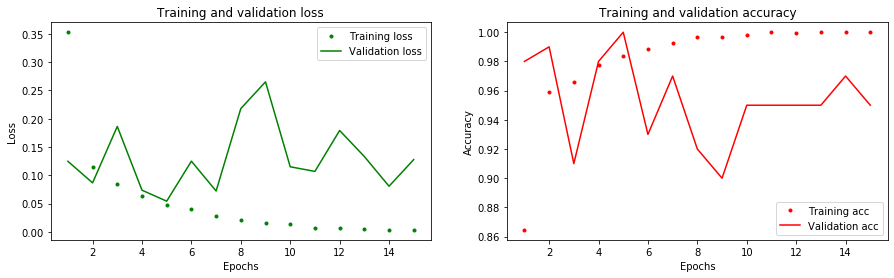

In [4]:
hist_cnn = history_1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The validation is divergent from the training past 5 epochs indicating a large degree of overfitting.  In future iterations, we will try dropout as a normalization technique to reduce overfitting.
***

## Model 2 - Basic CNN with Dropout and Max Pooling

In order to attempt to address the issue of overfitting, we add a max pooling layer and small dropout.

In [5]:
model_2 = models.Sequential()
model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64 ,64,  3)))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])

history_2 = model_2.fit(X_train,
                    Y_train,
                    epochs=15,
                    batch_size = 32,
                    validation_data=(X_val, Y_val))
score = model_2.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Epoch 1/15
161/161 [==============================] - 5s 32ms/step - loss: 0.2843 - acc: 0.8848 - precision_1: 0.8904 - recall_1: 0.9645 - auc_1: 0.9303 - val_loss: 0.1619 - val_acc: 0.9400 - val_precision_1: 0.9074 - val_recall_1: 0.9800 - val_auc_1: 0.9956
Epoch 2/15
161/161 [==============================] - 5s 30ms/step - loss: 0.1245 - acc: 0.9564 - precision_1: 0.9652 - recall_1: 0.9768 - auc_1: 0.9883 - val_loss: 0.0999 - val_acc: 0.9700 - val_precision_1: 0.9608 - val_recall_1: 0.9800 - val_auc_1: 0.9980
Epoch 3/15
161/161 [==============================] - 5s 31ms/step - loss: 0.0992 - acc: 0.9628 - precision_1: 0.9732 - recall_1: 0.9770 - auc_1: 0.9922 - val_loss: 0.0856 - val_acc: 0.9700 - val_precision_1: 0.9608 - val_recall_1: 0.9800 - val_auc_1: 0.9992
Epoch 4/15
161/161 [==============================] - 5s 30ms/step - loss: 0.0957 - acc: 0.9640 - precision_1: 0.9725 - recall_1: 0.9794 - auc_1: 0.9925 - val_loss: 0.0803 - val_acc: 0.9800 - val_precision_1: 0.9800 - val_r

#### Evaluation


The loss of the model is lower on the test set than the previous model, but it does not predict any better.  

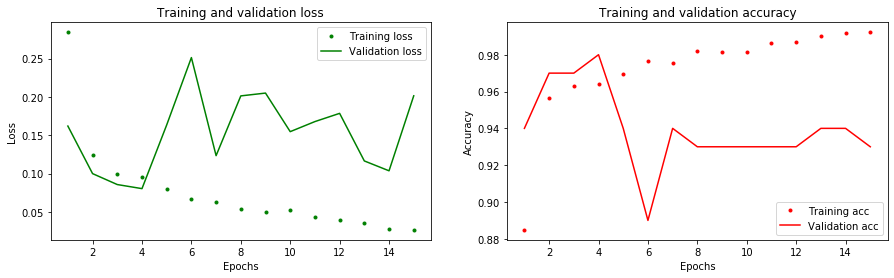

In [6]:
hist_cnn = history_2.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

For this model again, there is still a high degree of divergence between the training and test metrics after 4 epochs.
***

## Model 3

In order to capture more features in the data, extra complexity is added through another convolutional layer with max pooling and dropout.

In [7]:
model_3 = models.Sequential()
model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64 ,64,  3)))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten())
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])

history_3 = model_3.fit(X_train,
                    Y_train,
                    epochs=15,
                    batch_size = 32,
                    validation_data=(X_val, Y_val))
score = model_3.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Epoch 1/15
161/161 [==============================] - 9s 58ms/step - loss: 0.3765 - acc: 0.8357 - precision_2: 0.8382 - recall_2: 0.9666 - auc_2: 0.8608 - val_loss: 0.1922 - val_acc: 0.9500 - val_precision_2: 0.9787 - val_recall_2: 0.9200 - val_auc_2: 0.9860
Epoch 2/15
161/161 [==============================] - 9s 54ms/step - loss: 0.1562 - acc: 0.9419 - precision_2: 0.9573 - recall_2: 0.9653 - auc_2: 0.9808 - val_loss: 0.1497 - val_acc: 0.9300 - val_precision_2: 0.9057 - val_recall_2: 0.9600 - val_auc_2: 0.9920
Epoch 3/15
161/161 [==============================] - 9s 54ms/step - loss: 0.1206 - acc: 0.9534 - precision_2: 0.9672 - recall_2: 0.9705 - auc_2: 0.9881 - val_loss: 0.2065 - val_acc: 0.9200 - val_precision_2: 0.8621 - val_recall_2: 1.0000 - val_auc_2: 0.9934
Epoch 4/15
161/161 [==============================] - 9s 55ms/step - loss: 0.1085 - acc: 0.9616 - precision_2: 0.9712 - recall_2: 0.9776 - auc_2: 0.9901 - val_loss: 0.1350 - val_acc: 0.9400 - val_precision_2: 0.9400 - val_r

#### Evaluation

Adding an extra layer further reduced the loss of our classifier.  Additionally, it resulted in an increase in accuracy of ~10%, ~7% precision at the cost of a 1% drop in recall.

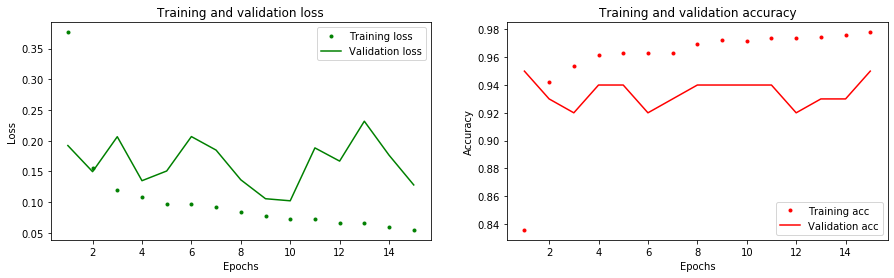

In [8]:
hist_cnn = history_3.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The addition of an extra layer with pooling and dropout seemed to have eliminated the extreme divergence between training and testing sets. 
***

## Model 4

In the previous iteration, the extra convolutional layer netted large gains for the classifier.  In this iteration, an extra fully connected layer will be added before the output layer to see if it improves.

In [9]:
model_4 = models.Sequential()
model_4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64 ,64,  3)))
model_4.add(MaxPooling2D((2, 2)))
model_4.add(Dropout(0.2))

model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))
model_4.add(Dropout(0.2))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])

history_4 = model_4.fit(X_train,
                    Y_train,
                    epochs=15,
                    batch_size = 32,
                    validation_data=(X_val, Y_val))
score = model_4.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Epoch 1/15
161/161 [==============================] - 10s 61ms/step - loss: 0.3643 - acc: 0.8338 - precision_3: 0.8339 - recall_3: 0.9708 - auc_3: 0.8788 - val_loss: 0.2334 - val_acc: 0.9600 - val_precision_3: 0.9423 - val_recall_3: 0.9800 - val_auc_3: 0.9960
Epoch 2/15
161/161 [==============================] - 9s 59ms/step - loss: 0.1754 - acc: 0.9322 - precision_3: 0.9460 - recall_3: 0.9643 - auc_3: 0.9754 - val_loss: 0.1362 - val_acc: 0.9400 - val_precision_3: 0.9074 - val_recall_3: 0.9800 - val_auc_3: 0.9958
Epoch 3/15
161/161 [==============================] - 9s 59ms/step - loss: 0.1331 - acc: 0.9501 - precision_3: 0.9659 - recall_3: 0.9674 - auc_3: 0.9853 - val_loss: 0.1474 - val_acc: 0.9400 - val_precision_3: 0.9074 - val_recall_3: 0.9800 - val_auc_3: 0.9926
Epoch 4/15
161/161 [==============================] - 9s 59ms/step - loss: 0.1138 - acc: 0.9560 - precision_3: 0.9730 - recall_3: 0.9679 - auc_3: 0.9890 - val_loss: 0.2380 - val_acc: 0.9300 - val_precision_3: 0.8772 - val_

#### Evaluation

The dense layer before the output further increased the accuracy and precision with no hit to the recall.

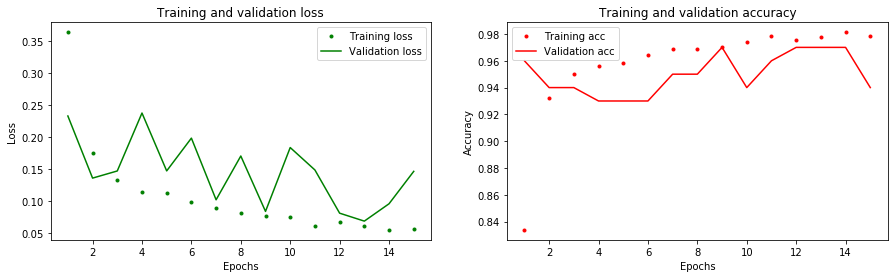

In [10]:
hist_cnn = history_4.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

While the performance of this model so far is the best, from the series data its clear that the model is still sensitive to noise and perhaps needs an adjusted learning rate.

## Model 5

For the final iteration, a third convolutional layer will be added, and the number of nodes within each will be adjusted.  Theoretically this should increase the number of features being examined in smaller and smaller feature maps within the model.  As the initial size of the image is 64 x 64 pixels, the resultant 3 x 3 kernal size feature maps hit the reduction limit after 3 layers.  

In [4]:
model_5 = models.Sequential()
model_5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64 ,64,  3)))
model_5.add(MaxPooling2D((2, 2)))
model_5.add(Dropout(0.2))

model_5.add(Conv2D(64, (3, 3), activation='relu'))
model_5.add(MaxPooling2D((2, 2)))
model_5.add(Dropout(0.2))

model_5.add(Conv2D(128, (3, 3), activation='relu'))
model_5.add(MaxPooling2D((2, 2)))
model_5.add(Dropout(0.2))

model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])

history_5 = model_5.fit(X_train,
                    Y_train,
                    epochs=15,
                    batch_size = 32,
                    validation_data=(X_val, Y_val))
score = model_5.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Epoch 1/15
161/161 [==============================] - 13s 80ms/step - loss: 0.3625 - acc: 0.8357 - precision_1: 0.8477 - recall_1: 0.9510 - auc_1: 0.8724 - val_loss: 0.3025 - val_acc: 0.8600 - val_precision_1: 0.7812 - val_recall_1: 1.0000 - val_auc_1: 0.9936
Epoch 2/15
161/161 [==============================] - 13s 78ms/step - loss: 0.1888 - acc: 0.9260 - precision_1: 0.9552 - recall_1: 0.9452 - auc_1: 0.9700 - val_loss: 0.1459 - val_acc: 0.9600 - val_precision_1: 0.9259 - val_recall_1: 1.0000 - val_auc_1: 0.9944
Epoch 3/15
161/161 [==============================] - 11s 68ms/step - loss: 0.1334 - acc: 0.9511 - precision_1: 0.9706 - recall_1: 0.9637 - auc_1: 0.9851 - val_loss: 0.1209 - val_acc: 0.9400 - val_precision_1: 0.9400 - val_recall_1: 0.9400 - val_auc_1: 0.9936
Epoch 4/15
161/161 [==============================] - 11s 68ms/step - loss: 0.1200 - acc: 0.9534 - precision_1: 0.9699 - recall_1: 0.9676 - auc_1: 0.9875 - val_loss: 0.1762 - val_acc: 0.9500 - val_precision_1: 0.9592 - v

#### Evaluation

For the fifth iteration, the model achieves an accuracy of 0.89, with a precision of 0.85, a recall of 0.99, and an AUC of 0.94 after 15 epochs of training.

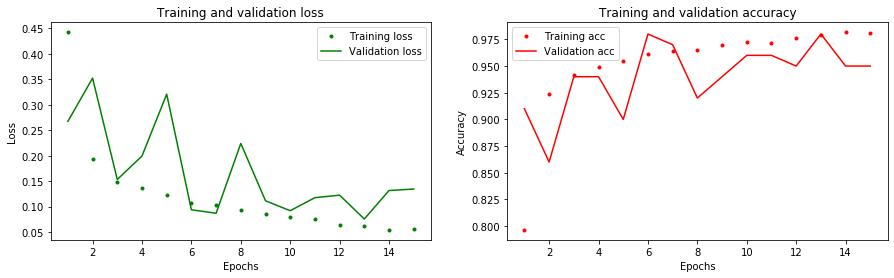

In [12]:
hist_cnn = history_5.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As the model trains, instead of becoming worse on the validation set, it performs better, indicating that this architecture is resistant to overfitting.  In future iterations, a lower learning rate, more epochs, and increased complexity are avenues to approach for improvement.

In [5]:
model_5.save('best_model.h5')

In [52]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
loaded_model = load_model('best_model.h5')
y_pred = (loaded_model.predict(X_test) > 0.6)
cm = confusion_matrix(Y_test, y_pred)

[Text(0.5, 0, 'Pneumonia'), Text(1.5, 0, 'Healthy')]

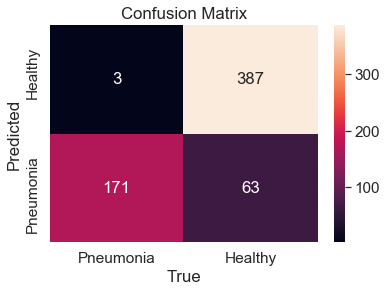

In [80]:
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_test, y_pred),
            annot = True,
            ax = ax,
            fmt = 'd')
ax.set_ylim([0,2])
ax.set_yticks([0.75, 1.75])
ax.set_title('Confusion Matrix')
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.yaxis.set_ticklabels(['Pneumonia', 'Healthy'])
ax.xaxis.set_ticklabels(['Pneumonia', 'Healthy'])